# Simple Object Detection

Using pre-trained models from TF Hub

#### References
- [TF2 object detection API tutorial](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_saved_model_tf1.html)
- [Reading pbtxt files in Python](https://stackoverflow.com/questions/55218726/how-to-open-pbtxt-file)

## Load libraries

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
from tensorflow.saved_model import load
from time import time
import collections

## Download model and labels

Since we are using pre-trained models, we just need the url from TF hub, as well as the labels for the dataset on which they were trained

### Efficientdet/d4

In [2]:
# model_url = "https://tfhub.dev/tensorflow/efficientdet/d4/1"
MODEL_NAME = "efficientdet_d4"

model_url = "https://tfhub.dev/tensorflow/efficientdet/d4/1?tf-hub-format=compressed"

In [3]:

model_path = get_file(MODEL_NAME, model_url, untar=True)
# print(model_path)

### Mobilenet SSD
[Hub link](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2)

In [34]:
MODEL_NAME = "ssd_mobilenet_v2"

model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2?tf-hub-format=compressed"

In [38]:
model_path = get_file(MODEL_NAME, model_url, untar=True)
print(model_path)

C:\Users\mamen\.keras\datasets\ssd_mobilenet_v2


### COCO2017 labelmap
https://github.com/tensorflow/models/blob/master/research/object_detection/data/mscoco_label_map.pbtxt

In [25]:
labels_path = get_file(
'mscoco_label_map.pbtxt','https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt')

In [ ]:
# coco_labels = np.array(open(labels_path).read().splitlines())

## Load labels

In [26]:
def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}

    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "display_name" in line:
                item_name = line.split(" ")[-1].replace("\"", " ").strip()
            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None

    return items

In [27]:
labels_dict = read_label_map(labels_path)

In [9]:
if 0 in labels_dict:
    print('yup', labels_dict[1])

## Helper functions

In [28]:
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

In [29]:
def draw_bbox_on_arr(img, ymin, xmin, ymax, xmax, color='red', thickness=2, display_str_list=(), use_normalized_coords=True):
    img_pil = Image.fromarray(np.uint8(img)).convert('RGB')
    draw_bbox_on_img(img_pil, ymin, xmin, ymax, xmax, color, thickness, display_str_list, use_normalized_coords)
    np.copyto(img, np.array(img_pil))


In [30]:
def draw_bbox_on_img(img, ymin, xmin, ymax, xmax, color='red', thickness=2, display_str_list=(), use_normalized_coords=True):
    draw = ImageDraw.Draw(img)
    im_w, im_h = img.size
    if use_normalized_coords:
        (left, right, top, bottom) = (xmin*im_w, xmax*im_w, ymin*im_h, ymax*im_h)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    if thickness>0:
        draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

    try:
        font = ImageFont.truetype('arial.ttf', 24)
    except IOError:
        font = ImageFont.load_default()

    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2*0.05)*sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    for display_str in display_str_list[::-1]:
        text_w, text_h = font.getsize(display_str)
        margin = np.ceil(0.05*text_h)
        draw.rectangle([(left, text_bottom - text_h -2*margin), (left+text_w, text_bottom)])
        draw.text((left+margin, text_bottom-text_h-margin), display_str, fill='black', font=font)
        text_bottom -= text_h - 2*margin


    

In [31]:
def viz_boxes_and_labels_on_arr(img, boxes, classes, scores, labels_dict, use_normalized_coords=True, max_boxes_to_draw=30, min_score_thresh=0.4):
    box_to_display_str_map = collections.defaultdict(list)
    box_to_color_map = collections.defaultdict(str)
    # box_to_instance_masks_maps = {}
    # box_to_instance_boundaries_maps = {}
    # box_to_keypoints_map = collections.defaultdict(list)
    # box_to_keypoint_scores_map = collections.defaultdict(list)
    # box_to_track_ids_map = {}
    if not max_boxes_to_draw:
        max_boxes_to_draw = boxes.shape[0]
    for i in range(boxes.shape[0]):
        if max_boxes_to_draw == len(box_to_color_map):
            break
        if scores is None or scores[i] > min_score_thresh:
            box = tuple(boxes[i].tolist())
            if scores is None:
                box_to_color_map[box] = 'black'
            else:
                display_str = ''
                if classes[i] in labels_dict:
                    class_name = labels_dict[classes[i]]
                else:
                    class_name ='N/A'
                display_str = str(class_name)

                if not display_str:
                    display_str = "{}%".format(round(100*scores[i]))
                else:
                    display_str = "{}:{}%".format(display_str, round(100*scores[i]))
                box_to_display_str_map[box].append(display_str)

                box_to_color_map[box] = STANDARD_COLORS[classes[i]%len(STANDARD_COLORS)]

    
    for box, color in box_to_color_map.items():
        ymin, xmin, ymax, xmax = box
        draw_bbox_on_arr(img, ymin, xmin, ymax, xmax, color=color, thickness=4, display_str_list=box_to_display_str_map[box], use_normalized_coords=use_normalized_coords)
    return img


In [32]:
def preds_as_numpy_dict(preds):
    detections = {}
    num_detections = int(preds['num_detections'])
    detections = {key:value[0, :num_detections].numpy() for key, value in preds.items()}
    detections['num_detections'] = num_detections
    return detections

## Load model

In [85]:
start = time()

model = load(model_path)

elapsed = time() - start

print("Time to load model: {} sec".format(elapsed))

Time to load model: 67.34777617454529 sec


## Visualize and preprocess sample image

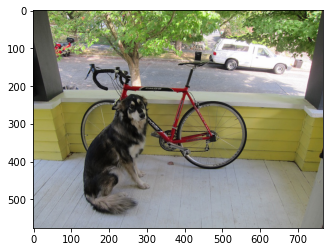

In [69]:
image_file = "dog_bike_car.jpg"

img_input = Image.open(image_file)
plt.imshow(img_input)

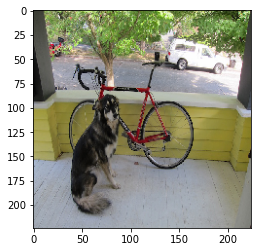

In [45]:
img_input = img_input.resize((224,224), Image.NEAREST)
plt.imshow(img_input)

In [81]:
img_input.size

(768, 576)

In [70]:
img_arr = image.img_to_array(img_input)
print(img_arr.shape)

(576, 768, 3)


In [71]:
img_arr = img_arr.reshape(1,576,768,3)

In [88]:
start = time()
out_base = model(img_arr)

elapsed = time() - start

print("Time for inference: {} sec".format(elapsed))

AttributeError: '_UserObject' object has no attribute 'predict'

In [87]:
out_base.keys()

dict_keys(['detection_anchor_indices', 'detection_boxes', 'detection_classes', 'detection_multiclass_scores', 'detection_scores', 'num_detections', 'raw_detection_boxes', 'raw_detection_scores'])

InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/

In [51]:
int(out_base['num_detections'])

100

In [73]:
out_base['detection_classes'] = out_base['detection_classes'].numpy().astype(np.int64)

In [74]:
out_base['detection_classes'][0]

array([ 2, 18,  3,  8,  1,  3,  3,  7,  3,  1, 18, 64,  1,  8,  3,  3, 62,
        3, 18, 15,  3,  2, 17,  1,  3,  1, 64, 62,  8,  2,  3,  3, 15, 64,
        3, 15,  8,  3, 64, 65, 15, 13,  3, 64, 17, 15,  1, 10,  1, 62,  2,
        3,  8,  3,  3, 10,  3,  2,  8, 62,  1,  8,  8,  2,  3,  2, 72,  3,
        3,  7, 13, 27,  8,  1,  2, 62, 62,  1, 64, 10,  1, 15, 64, 10,  4,
        2,  4,  7, 14, 10, 64, 18, 15,  8,  1,  1,  3,  2,  2,  3],
      dtype=int64)

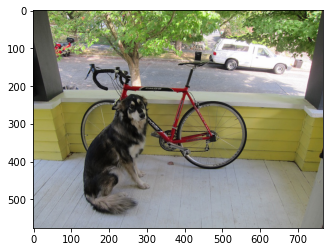

In [75]:
img_numpy = img_arr.astype(np.uint8).copy()
plt.imshow(img_numpy[0])

In [76]:
img_numpy.shape

(1, 576, 768, 3)

In [77]:
viz_boxes_and_labels_on_arr(img_numpy[0], out_base['detection_boxes'].numpy()[0], out_base['detection_classes'][0], out_base['detection_scores'].numpy()[0], labels_dict, max_boxes_to_draw=20, min_score_thresh=.6, use_normalized_coords=True)

array([[[ 57,  58,  50],
        [ 58,  59,  51],
        [ 60,  61,  53],
        ...,
        [143,  89,  43],
        [ 89,  49,  41],
        [ 65,  70,  47]],

       [[ 58,  59,  51],
        [ 58,  59,  51],
        [ 59,  60,  52],
        ...,
        [124,  75,  35],
        [ 84,  50,  41],
        [ 58,  70,  46]],

       [[ 58,  59,  51],
        [ 58,  59,  51],
        [ 59,  60,  52],
        ...,
        [ 98,  54,  25],
        [ 78,  53,  48],
        [ 44,  63,  41]],

       ...,

       [[160, 168, 179],
        [160, 168, 179],
        [163, 171, 182],
        ...,
        [ 80,  64,  64],
        [ 53,  39,  36],
        [ 62,  53,  48]],

       [[161, 169, 180],
        [160, 168, 179],
        [156, 164, 175],
        ...,
        [ 79,  61,  61],
        [ 54,  40,  37],
        [ 67,  56,  52]],

       [[157, 165, 176],
        [159, 167, 178],
        [153, 161, 172],
        ...,
        [ 80,  62,  62],
        [ 51,  36,  33],
        [ 50,  39,  35]]

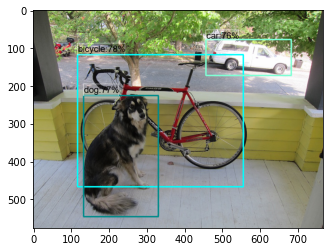

In [78]:
plt.imshow(img_numpy[0].astype(np.uint8))

In [89]:
def getPredictions(image_file, model):
	img_input = Image.open(image_file)
	im_w, im_h = img_input.size
	img_arr = image.img_to_array(img_input)
	img_arr = img_arr.reshape(1,im_h,im_w,3)
	# start = perf_counter()
	out_base = model(img_arr)
	# elapsed = perf_counter() - start
	# print("Time for inference: {} sec".format(elapsed))
	return out_base

In [91]:
out_new = getPredictions(image_file, model)

In [92]:
out_new.keys()

dict_keys(['detection_anchor_indices', 'detection_boxes', 'detection_classes', 'detection_multiclass_scores', 'detection_scores', 'num_detections', 'raw_detection_boxes', 'raw_detection_scores'])